In [8]:
import pandas as pd
from bioc import biocxml
from numpy.ma.extras import average
from sqlalchemy.testing.plugin.plugin_base import config

from knowledge_engine.models.ontology_match import OntologyMatch
from notebooks.processing_utils import parse_document
from typing import Dict
import torch

In [9]:
from bioengine.dochandlers.bioc_dataset import BioCDataset, BioCPreprocessor

In [10]:
stats = BioCPreprocessor("../data/BioRED/Train.BioC.XML").analyze_bioc_file()
set(stats['relation_types'].keys())

{'Association',
 'Bind',
 'Comparison',
 'Conversion',
 'Cotreatment',
 'Drug_Interaction',
 'Negative_Correlation',
 'Positive_Correlation'}

In [11]:
class Config:
    # Model settings
    # model_name = "dmis-lab/biobert-base-cased-v1.2"  # BioBERT for biomedical text
    model_name = "dmis-lab/biobert-v1.1"  # BioBERT for biomedical text
    max_length = 512
    hidden_size = 768

    # Training settings
    batch_size = 16
    learning_rate = 2e-5
    num_epochs = 3
    dropout = 0.1

    # Relationship types
    relation_types = [
        *set(stats['relation_types'].keys()),
        "no_relation"  #include negative class
    ]

    num_relations = len(relation_types)
    relation_to_id = {rel: idx for idx, rel in enumerate(relation_types)}
    id_to_relation = {idx: rel for idx, rel in enumerate(relation_types)}


In [14]:
dataset = BioCDataset('../data/BioRED/Train.BioC.XML', config=Config())
dataset[0]

Loaded 3831 relation examples from 400 documents
2025-09-02 09:02:20,397 - urllib3.connectionpool - DEBUG - https://huggingface.co:443 "HEAD /dmis-lab/biobert-v1.1/resolve/main/tokenizer_config.json HTTP/1.1" 307 0
2025-09-02 09:02:20,426 - urllib3.connectionpool - DEBUG - https://huggingface.co:443 "HEAD /api/resolve-cache/models/dmis-lab/biobert-v1.1/551ca18efd7f052c8dfa0b01c94c2a8e68bc5488/tokenizer_config.json HTTP/1.1" 200 0
2025-09-02 09:02:20,611 - urllib3.connectionpool - DEBUG - https://huggingface.co:443 "GET /api/models/dmis-lab/biobert-v1.1/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


{'input_ids': tensor([[  101, 28996,  1124,  4163,  2430,  3457,  1566,  4272,  5318,   118,
            127, 28997,   131,  9815,  1206,  7434, 15661, 26468,  1105, 28998,
           2076,  1563, 17972, 28999,  1105,  1206,  7434, 15661, 26468,  1105,
          10777,  1104, 26825,  3318,  1988,   119,  1109, 15416,  5318,  1119,
           4163,  2430,  3457,  1566,  4272,  5318,   113,   145, 28047,   114,
            118,   127,  1110,  1126, 15011, 27335,  1104,  1317,  9077,  2017,
           1107,  1103,  3507, 19790, 16317,  1104, 18462,   118, 15415, 17972,
           1104,  1103,  1685,   119,  1284,  3335,  7289,  1103, 11066,  1115,
          15661, 26468,  1107,  1103,   145, 28047,   118,   127,  5565,  1110,
           2628,  1114, 18005,  1116,  1104,  6902,  1563,   113,  1664,   118,
          26825,   118,  7449,   114, 17972,  1143,  6473,  4814,  1105, 10777,
           1104, 26825,  3318,  1988,  1107, 20636, 26827,  5174,   119,  1284,
          22121,  1181,  11

In [6]:
dataset[0]['relation_label'].shape

torch.Size([])

In [20]:
from torch.utils.data import DataLoader

class Batch:
    def __init__(self, data):
        self.attention_mask = torch.cat([item['attention_mask'] for item in data])
        self.input_ids = torch.cat([item['input_ids'] for item in data])
        self.relation_label =  torch.stack([item['relation_label'] for item in data])
        self.extra = data

    # custom memory pinning method on custom type
    # def pin_memory(self):
    #     self.inp = self.inp.pin_memory()
    #     self.tgt = self.tgt.pin_memory()
    #     return self
    def __getitem__(self, item):
         return getattr(self, item)

def collate_wrapper(batch):
    return Batch(batch)

batched_dataset = DataLoader(dataset, batch_size=10, shuffle=True, collate_fn=collate_wrapper)
# for batch in batched_dataset:
#     batch

In [21]:
from transformers import AutoModel
from torch import nn

from transformers import BertModel
import torch.nn as nn
class SimpleRelationModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.encoder = BertModel.from_pretrained(config.model_name)
        self.dropout = nn.Dropout(0.1,inplace=False)
        self.classifier = nn.Linear(config.hidden_size, config.num_relations)
    def forward(self, x, attention_mask ,label=None):
        x = self.encoder(x, attention_mask=attention_mask)[0]
        x = x[:, 0, :]
        # x = self.dropout(x)
        # x = self.fc(x)
                # Apply dropout and classify
        x = self.dropout(x)
        logits = self.classifier(x)  # [batch_size, num_relations]

        return logits

from transformers import AutoTokenizer
import torch
config = Config()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Tokenizer with special tokens
# tokenizer = AutoTokenizer.from_pretrained(config.model_name, return_tensors="pt")
# special_tokens = ["[E1]", "[/E1]", "[E2]", "[/E2]"]
# tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})

from torch import optim

model = SimpleRelationModel(config)
model.encoder.resize_token_embeddings(len(dataset.tokenizer))  # Resize for special tokens
model.to(device)

# 6. Optimizer and loss
optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
criterion = nn.CrossEntropyLoss()

model.train()
print("Starting training...")

for epoch in range(config.num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch_idx, batch in enumerate(batched_dataset):
        # Move to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["relation_label"].to(device)

        # Forward pass
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)

        # Compute loss
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

        # Print progress
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch+1}/{config.num_epochs}, Batch {batch_idx}/{len(dataset)}, "
                  f"Loss: {loss.item():.4f}")

    # Epoch summary
    avg_loss = total_loss / len(dataset)
    accuracy = correct_predictions / total_predictions
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Using device: mps
2025-09-02 09:07:06,673 - urllib3.connectionpool - DEBUG - https://huggingface.co:443 "HEAD /dmis-lab/biobert-v1.1/resolve/main/config.json HTTP/1.1" 307 0
2025-09-02 09:07:06,714 - urllib3.connectionpool - DEBUG - https://huggingface.co:443 "HEAD /api/resolve-cache/models/dmis-lab/biobert-v1.1/551ca18efd7f052c8dfa0b01c94c2a8e68bc5488/config.json HTTP/1.1" 200 0
2025-09-02 09:07:06,861 - urllib3.connectionpool - DEBUG - https://huggingface.co:443 "HEAD /dmis-lab/biobert-v1.1/resolve/main/config.json HTTP/1.1" 307 0
2025-09-02 09:07:06,895 - urllib3.connectionpool - DEBUG - https://huggingface.co:443 "HEAD /api/resolve-cache/models/dmis-lab/biobert-v1.1/551ca18efd7f052c8dfa0b01c94c2a8e68bc5488/config.json HTTP/1.1" 200 0
2025-09-02 09:07:07,043 - urllib3.connectionpool - DEBUG - https://huggingface.co:443 "HEAD /dmis-lab/biobert-v1.1/resolve/main/model.safetensors HTTP/1.1" 404 0
2025-09-02 09:07:07,055 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (

RuntimeError: MPS backend out of memory (MPS allocated: 18.05 GiB, other allocations: 672.00 KiB, max allowed: 18.13 GiB). Tried to allocate 84.96 MiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

2025-09-02 09:07:08,147 - urllib3.connectionpool - DEBUG - https://huggingface.co:443 "GET /api/models/dmis-lab/biobert-v1.1/commits/refs%2Fpr%2F9 HTTP/1.1" 200 3950


In [15]:
torch.save({
        'model_state_dict': model.state_dict(),
        'config': config,
        'tokenizer': dataset.tokenizer
    }, 'simple_relation_model.pt')

In [16]:
test_dataset = BioCDataset('../data/BioRED/Test.BioC.XML', config=Config())

Loaded 990 relation examples from 100 documents
2025-08-29 11:11:08,732 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (3): huggingface.co:443
2025-08-29 11:11:09,079 - urllib3.connectionpool - DEBUG - https://huggingface.co:443 "GET /api/models/dmis-lab/biobert-v1.1/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


In [17]:
test_dataset[0]

{'input_ids': tensor([[  101,   138,  2281, 28998,  9314,  2249,  1571,  1592, 28999, 17895,
          23487,  1116,  1112,   170, 12477,  2646, 15454,  1532,  1104,  1263,
            154,  1942,  9318,  1114,  1679,  2983,  6163, 15415,  1104, 27629,
           8992, 10542,  1465,   120, 28996, 12418,  3810, 10542,  1465, 28997,
            119,   152,  2064,  4538,  8231, 21669, 17145,   131, 16752,  4915,
          19058,  1263,   154,  1942,  9318,   113,   149,  4880, 11365,   114,
           1114,  1107,   190, 25710, 15415,  1104,  1103,  6795, 19019,  1116,
           1110,  2628,  1114,   170,  2869,  5250, 25566,  4863,   119,  1130,
           1142,  2025,  1195, 10788,   170, 24820,  5351,  1114,   175, 21470,
          12418,  3810, 10542,  1465,   117,   123,   131,   122,  1120,  8558,
          14850,  4907,  5552,  3510,  1105, 21828,  4907,  5552, 27629,  8992,
          10542,  1465,  1770,  1170,  3485,   119, 22157, 24162, 15609,  1708,
            131, 19569,  79

In [26]:
all_predictions = []
all_labels = []
all_probabilities = []
for batch in dataset:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["relation_label"].to(device)

    # Forward pass
    logits = model(input_ids, attention_mask)

    # Get predictions and probabilities
    probabilities = torch.softmax(logits, dim=1)
    predictions = torch.argmax(logits, dim=1)

    # Store results
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend([batch["relation_label"].item()])
    all_probabilities.extend(probabilities.cpu().detach().numpy()[0])

In [46]:
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_fscore_support, classification_report

In [30]:
f1_score(all_labels, all_predictions, average='weighted')

0.6577547407822327

2025-08-29 11:28:30,414 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-29 11:28:30,415 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-29 11:28:30,422 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-08-29 11:28:30,424 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/opt/homebrew/Caskroom/mambaforge/base/envs/ontosemantics/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-08-29 11:28:30,424 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/opt/homebrew/Caskroom/mambaforge/base/envs/ontosemantics/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.t

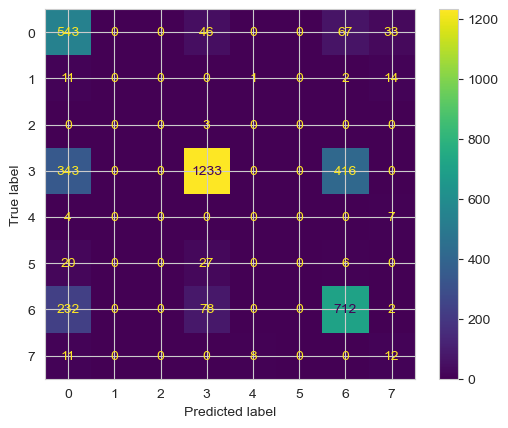

In [36]:
ConfusionMatrixDisplay.from_predictions(all_labels, all_predictions)

In [43]:
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        all_labels, all_predictions, average=None, zero_division=0
    )

In [45]:
recall_per_class

array([0.78809869, 0.        , 0.        , 0.6189759 , 0.        ,
       0.        , 0.6953125 , 0.38709677])

In [48]:
target_names = [config.id_to_relation[i] for i in range(config.num_relations)]
class_report = classification_report(all_labels, all_predictions, target_names=target_names[:8], output_dict=True)


/opt/homebrew/Caskroom/mambaforge/base/envs/ontosemantics/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/mambaforge/base/envs/ontosemantics/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/mambaforge/base/envs/ontosemantics/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter

In [49]:
class_report

{'Negative_Correlation': {'precision': 0.46649484536082475,
  'recall': 0.7880986937590712,
  'f1-score': 0.5860766324878576,
  'support': 689.0},
 'Comparison': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 28.0},
 'Conversion': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 3.0},
 'Association': {'precision': 0.8889689978370584,
  'recall': 0.6189759036144579,
  'f1-score': 0.7298017164841669,
  'support': 1992.0},
 'Drug_Interaction': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 11.0},
 'Bind': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 53.0},
 'Positive_Correlation': {'precision': 0.5918536990856192,
  'recall': 0.6953125,
  'f1-score': 0.6394252357431522,
  'support': 1024.0},
 'Cotreatment': {'precision': 0.17647058823529413,
  'recall': 0.3870967741935484,
  'f1-score': 0.24242424242424243,
  'support': 31.0},
 'accuracy': 0.6525711302531976,
 'macro avg': {'precision': 0.26547351631484956,
  'r